In [1]:
# # before we start, load our necessary files

# !wget https://github.com/oanaucs/tutorial_RPCMCI_CCAI24/raw/4770ecc8a404e10b0d5b22706b22c63b9245c709/to_download.zip -O file.zip

In [2]:
# !unzip file.zip

In [3]:
# !python --version

In [4]:
# !pip3 install numba==0.56.4  matplotlib==3.8.0 networkx==3.1 numpy==1.23.5 pandas==2.1.4 scikit-learn==1.3.0 scipy==1.11.4 seaborn==0.12.2 ortools==9.8.3296 gdown

In [5]:
# !wget https://github.com/jakobrunge/tigramite/archive/refs/heads/master.zip

In [6]:
# # unzip the Tigramite folder - necessary for installation
# !unzip master.zip

In [7]:
# # temporarily change directory
# %cd tigramite-master

In [8]:
# # install Tigramite
# !python setup.py install

In [9]:
# # go back to root dir
# %cd ..

In [10]:
# imports
import copy

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from datetime import datetime, timedelta

# Metrics and Evaluation
from sklearn.metrics import confusion_matrix

In [11]:
# Data preprocessing and graph visualization
from tigramite import data_processing as pp
from tigramite import plotting as tp
# Causal discovery
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.pcmci import PCMCI
from rpcmci import RPCMCI
import networkx as nx

In [12]:
import gdown

url = 'https://drive.google.com/uc?id=1kNZBz1ie-BVwwFF5W1kNikk1CjbTtZvu'
output = 'LAF_WWCE_SM_VAC_dtr_std_MAMJJAS.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1kNZBz1ie-BVwwFF5W1kNikk1CjbTtZvu
To: /Users/tyler/local-docs/CMU/Introduction-to-Deep-Learning/Project/LAF_WWCE_SM_VAC_dtr_std_MAMJJAS.csv
100%|██████████| 14.9M/14.9M [00:00<00:00, 28.6MB/s]


'LAF_WWCE_SM_VAC_dtr_std_MAMJJAS.csv'

In [13]:
def reshape_and_resample_df(filename, val_type='seasonal_dtr_val_std', sample_freq='3D', sampling_type='mean',
                            fill_missing=False, fill_missing_value=999., use_evap=False):
    # Load DataFrame
    df = pd.read_csv(filename)
    freq = int(sample_freq[0])

    # Convert 'VAC' values
    vac_conversion = {'a': 1, 'b': 2, 'c': 3, 'd': 4, '0': 0}
    df['VAC'] = df['VAC'].replace(vac_conversion).astype(float)

    # Pivot the DataFrame
    pivoted_df = df.pivot(index='date', columns='var', values=val_type)
    pivoted_df.index = pd.to_datetime(pivoted_df.index)

    # only keep years starting from 1990
    all_days_to_keep = np.arange(datetime(1993, 3, 1), datetime(2022, 9, 30),
                                 timedelta(days=1)).astype(datetime)
    dates_to_keep = [i for i in all_days_to_keep if i in pivoted_df.index]
    pivoted_df = pivoted_df.loc[dates_to_keep]

    if use_evap:
        pivoted_df['evap'] = pivoted_df['slhf'] / pivoted_df['slhf'] + \
        pivoted_df['sshf']

    # Extract and prepare 'VAC' column
    date_to_vac = df.drop_duplicates(subset='date').set_index('date')['VAC']
    date_to_vac.index = pd.to_datetime(date_to_vac.index)
    date_to_vac = date_to_vac.loc[dates_to_keep]

    if fill_missing:
        date_array = pivoted_df.index

        # fill in missing days with 999.
        filled_df = pd.DataFrame(fill_missing_value, index=all_days_to_keep,
                                 columns=pivoted_df.columns)
        filled_df.index = pd.to_datetime(filled_df.index).strftime('%Y-%m-%d')

        filled_vac_df = pd.Series(fill_missing_value, index=all_days_to_keep)
        filled_vac_df.index = pd.to_datetime(
            filled_vac_df.index).strftime('%Y-%m-%d')

        for day in filled_df.index:
            if day in date_array:
                filled_df.loc[day] = pivoted_df.loc[day]
                filled_vac_df.loc[day] = date_to_vac.loc[day]

        pivoted_df = filled_df
        date_to_vac = filled_vac_df

    # Resample data
    if sampling_type == 'mean':
        resampled = pivoted_df.copy().resample(sample_freq).mean().dropna()
        resampled_vac = np.round(
            date_to_vac.resample(sample_freq).median().dropna())
    elif sampling_type == 'subsample':
        # Assuming 'sample_freq' contains a valid integer for frequency
        resampled = pivoted_df.copy().iloc[::freq]
        resampled_vac = date_to_vac.iloc[::freq]
    else:
        raise ValueError('This type of sampling is not supported!')

    # Assign 'VAC' values to the resampled DataFrame
    resampled['VAC'] = resampled_vac

    return resampled

In [14]:
def get_pandas_and_tigramite_dfs(filename, val_type='seasonal_dtr_val_std', sample_freq='1D', sampling_type='mean',
                                 vals_to_drop=None, fill_missing=False, fill_missing_value=999., use_evap=False):
    # Reshape and resample DataFrame
    pd_df = reshape_and_resample_df(filename, val_type=val_type,
                                    sample_freq=sample_freq,
                                    sampling_type=sampling_type,
                                    fill_missing=fill_missing,
                                    fill_missing_value=fill_missing_value,
                                    use_evap=use_evap)

    vac_values = pd_df['VAC'].copy().to_numpy()

    # rename columns
    pd_df = pd_df.rename(columns={'slhf': 'LH',
                                  'sshf': 'SH',
                                  'swvl123': 'SM',
                                  't2m': 'T2m',
                                  'tp': 'TP',
                                  'stream': 'Stream',
                                  'ssrd': 'SW'})

    # Drop specified columns if provided
    if vals_to_drop is not None:
        pd_df.drop(vals_to_drop, axis=1, inplace=True)

    # Convert to new DataFrame with appropriate column names
    tig_df = pp.DataFrame(pd_df.to_numpy(), var_names=pd_df.columns, missing_flag=999.)

    return pd_df, tig_df, vac_values

In [47]:
filled_pd_df, filled_tigramite_df, filled_vac_values = get_pandas_and_tigramite_dfs(
    './LAF_WWCE_SM_VAC_dtr_std_MAMJJAS.csv',
    sampling_type='subsample',
    sample_freq='3D',
    vals_to_drop=['swvl2', 'swvl3', 'swvl1', 'VAC'],
    fill_missing=True, fill_missing_value=999., use_evap=False)

filled_pd_df

var,LH,SH,SW,Stream,SM,T2m,TP
1993-03-01,-2.002010,-1.700595,-1.388422,-0.961006,1.000301,-2.468754,-0.410785
1993-03-04,-2.079535,0.269864,-1.373883,-0.966262,0.976103,-2.829865,-0.804691
1993-03-07,-2.313179,-1.212047,-1.766511,0.247366,0.944048,-1.874465,-0.566229
1993-03-10,-1.891900,-1.083334,-0.699963,0.091008,0.836672,-1.732115,-1.119150
1993-03-13,-1.515572,-1.033143,-0.429125,-0.259905,0.704316,-1.209977,-1.138493
...,...,...,...,...,...,...,...
2022-09-16,-0.519371,-0.671320,-1.357689,0.472257,-1.067097,-0.195258,0.631603
2022-09-19,-0.641500,-0.597558,-0.887577,0.394249,-0.934047,-0.611371,-0.078863
2022-09-22,-0.973898,0.007064,-0.387888,0.820718,-0.998225,-0.644752,-1.036081
2022-09-25,-1.214774,-1.058357,-1.717759,0.064268,-0.898910,-0.458938,0.744294


In [16]:
filled_pd_df_vac, filled_tigramite_df_vac, _ = get_pandas_and_tigramite_dfs(
    './LAF_WWCE_SM_VAC_dtr_std_MAMJJAS.csv',
    sampling_type='subsample',
    sample_freq='3D',
    vals_to_drop=['swvl2', 'swvl3', 'swvl1'],
    fill_missing=True, fill_missing_value=999., use_evap=False)

In [17]:
def plot_timeseries_and_correlations(dataframe, tau_max=10):
    timeseries_fig, timeseries_axs = tp.plot_timeseries(dataframe, figsize=(8, 4), grey_masked_samples='data')
    parcorr = ParCorr(significance='analytic')
    pcmci = PCMCI(
        dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=1)
    correlations = pcmci.get_lagged_dependencies(tau_max=tau_max, val_only=True)['val_matrix']
    matrix_lags = None
    tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags': matrix_lags})
    lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names': dataframe.var_names,
                                                                            'x_base': 5, 'y_base': .5})
    plt.show()


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 10


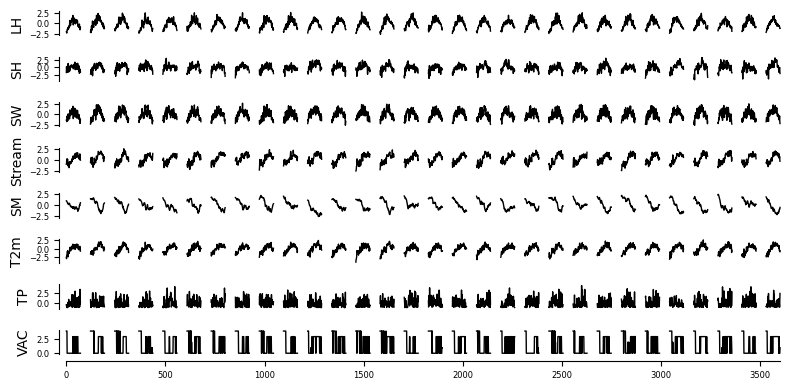

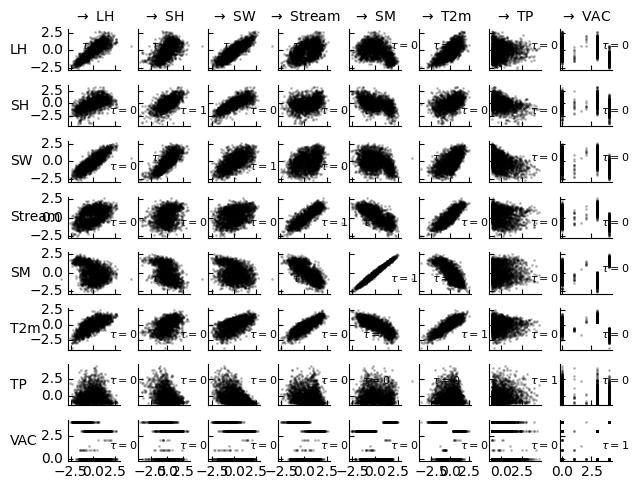

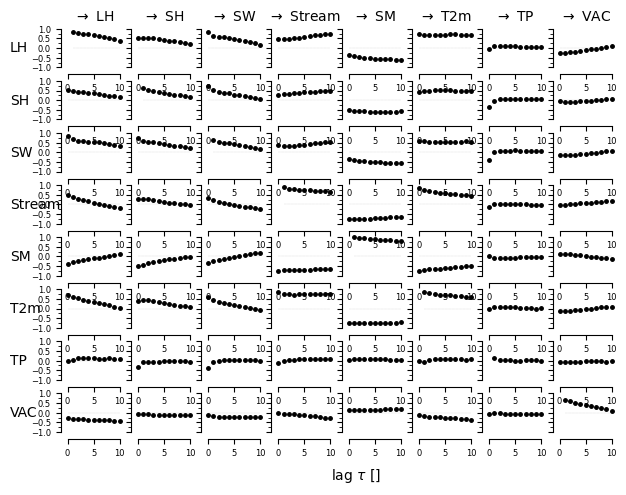

In [18]:
plot_timeseries_and_correlations(filled_tigramite_df_vac)

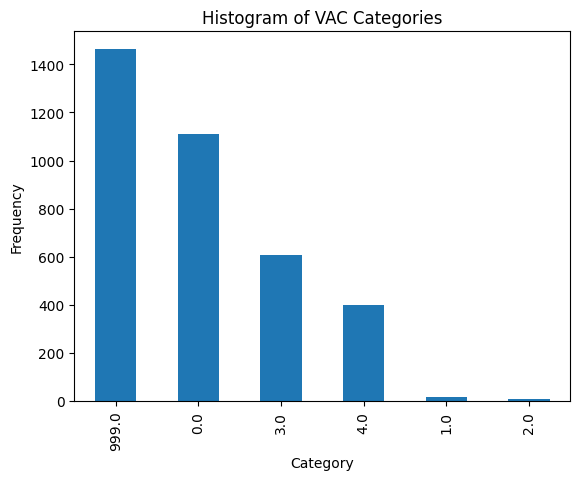

In [19]:
filled_pd_df_vac['VAC'].value_counts().plot(kind='bar')
plt.title('Histogram of VAC Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

filled_pd_df_vac.index = pd.to_datetime(filled_pd_df_vac.index)

In [20]:
def group_and_plot_by_month(dataframe):
    # Group by 'Month' and 'VAC', then count occurrences
    monthly_vac_counts = dataframe.groupby(['Month', 'VAC']).size().unstack(fill_value=0)

    # Plotting the aggregated monthly counts as stacked bars
    monthly_vac_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
    plt.title('Monthly Frequency of VAC Categories Aggregated Over Years')
    plt.xlabel('Month')
    plt.ylabel('Frequency')
    plt.legend(title='VAC Category')
    plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    plt.show()

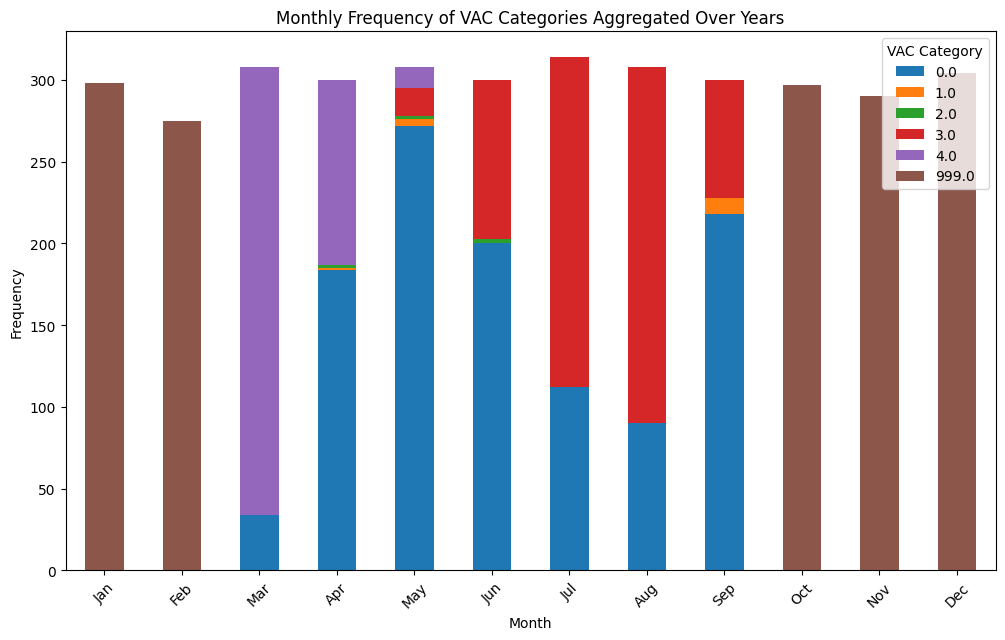

In [21]:
# Create a 'Month' column by extracting the month from the index
filled_pd_df_vac['Month'] = filled_pd_df_vac.index.month

group_and_plot_by_month(filled_pd_df_vac)


We now group the VAC indices for the dry and the moist regimes such that in the end we obtain $3$ total VAC indices. Then, we plot again the monthly distribution to ensure that we have the correct assignments.

So now the new assignemnt of the regimes is :

0 - normal
1 - dry regime
2 - wet regime

In [22]:
vac_regimes_reduced = {0: 0, 1: 0, 2: 0, 3: 1, 4: 0}
filled_pd_df_vac['VAC'] = filled_pd_df_vac['VAC'].replace(vac_regimes_reduced).astype(float)

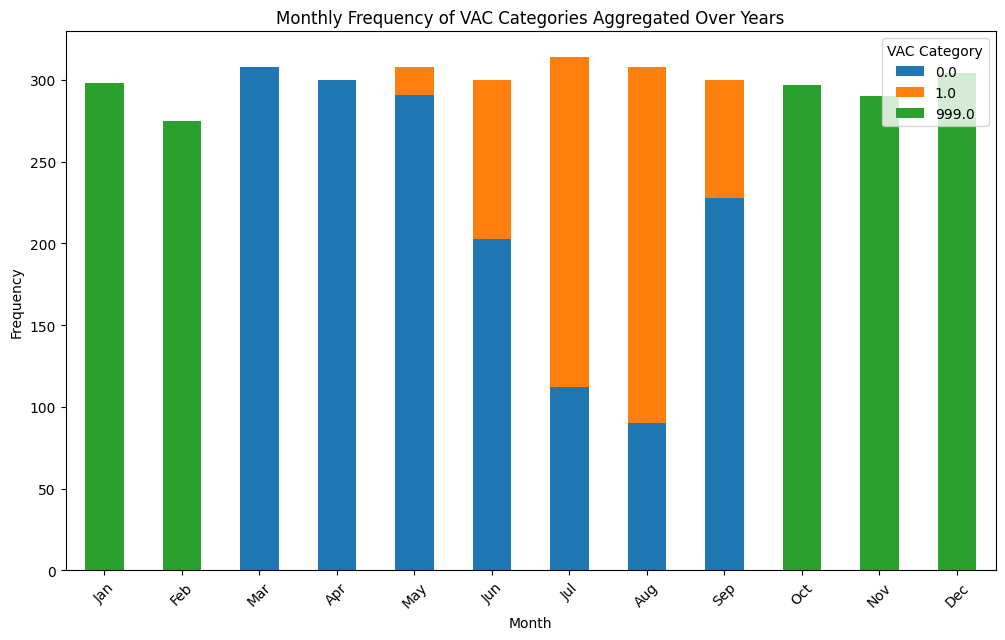

In [23]:
group_and_plot_by_month(filled_pd_df_vac)

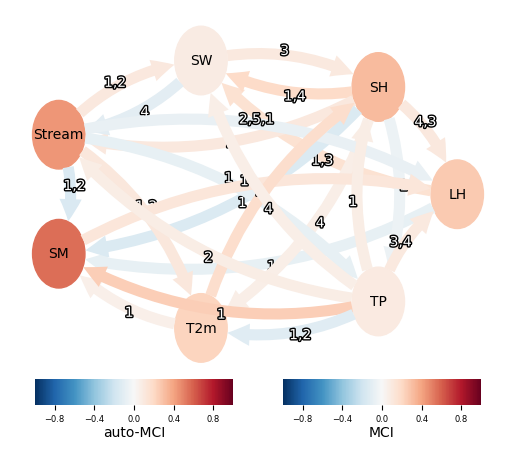

In [24]:
# Set hyperparameters
tau_min = 1
tau_max = 5
pc_alpha = None
alpha_level = 0.01

pcmci = PCMCI(dataframe=filled_tigramite_df,
              cond_ind_test=RobustParCorr())

pcmci_results = pcmci.run_pcmci(tau_min=tau_min, tau_max=tau_max, pc_alpha=pc_alpha, alpha_level=alpha_level)

tp.plot_graph(val_matrix=pcmci_results['val_matrix'],
              graph=pcmci_results['graph'], var_names=filled_tigramite_df.var_names,
              node_aspect=0.5, node_size=0.5
              )
plt.show()

In [25]:
def run_rpcmci(dataframe, num_regimes, max_transitions, switch_thres,
               num_iterations=10, max_anneal=10, alpha_level=0.01,
               tau_min=1, tau_max=5,
               link_assumptions=None,
               pc_alpha=0.4, prediction_model=DecisionTreeRegressor(),
               run_parallel=False):
    # Init RPCMCI with the dataframe, a conditional independence test for use in PCMCI,
    # and a prediction_model which is used to predict each variable given its learned parents. This prediction
    # is then used inside the regime learning optimization step.
    rpcmci = RPCMCI(dataframe=dataframe,
                    cond_ind_test=RobustParCorr(),
                    prediction_model=prediction_model,
                    link_assumptions=link_assumptions,
                    seed=847,
                    run_parallel=run_parallel,
                    verbosity=3)

    # Run RPCMCI
    results = rpcmci.run_rpcmci(
        num_regimes=num_regimes,
        max_transitions=max_transitions,
        num_iterations=num_iterations,
        switch_thres=switch_thres,
        max_anneal=max_anneal,
        tau_min=tau_min,
        tau_max=tau_max,
        pc_alpha=pc_alpha,
        alpha_level=alpha_level,
        n_jobs=-1,
        )

    if results is None:
        print("All annealings resulted in errors. Increase annealing and tune other parameters!")
    else:
        print("Done!")

    return results

In [26]:
vac_df = pd.DataFrame(filled_vac_values, columns=['VAC'])
vac_df = vac_df[vac_df['VAC'] != 999.]

vac_df['shifted_VAC'] = vac_df['VAC'].shift(-1)  # Shift the category column by one row to compare
vac_df['changed'] = vac_df['VAC'] != vac_df['shifted_VAC']  # True if the next row is a different category

# Calculate sequence lengths
# Assign a group number to each sequence by cumulatively summing the 'is_change' column
vac_df['group'] = vac_df['changed'].cumsum()
# Count the occurrences of each group to get the sequence lengths
sequence_lengths = vac_df.groupby('group').size()

# Step 3: Compute the average sequence length
average_sequence_length = sequence_lengths.mean()

print('Regime average sequence length', average_sequence_length)


Regime average sequence length 5.018779342723005


In [27]:
num_regimes = 3
max_transitions = int(
    np.round(vac_df.shape[0] / (average_sequence_length * num_regimes)))
print('Number of max. transitions', max_transitions)

Number of max. transitions 142


In [28]:
def plot_RPCMCI_results(pd_dataframe, vac_values, results):
    T, N = pd_dataframe.to_numpy().shape
    datatime = np.arange(T)
    regimes = results['regimes'].argmax(axis=0)
    n_regimes = len(results['causal_results'])
    var_names = pd_dataframe.columns
    # Create nice Mosaic plot
    mosaic = [['data %s' % j for i in range(n_regimes)] for j in range(N + 2)]
    for n in range(N):
        mosaic.append(['graph %s' % i for i in range(n_regimes)])

    fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(20, 10))

    for j in range(N):
        ax = axs['data %s' % j]
        ax.axhline(0., color='grey')
        data = copy.deepcopy(pd_dataframe.to_numpy())
        data[data == 999.] = np.nan
        ax.plot(datatime, data[:, j])
        ax.plot(datatime, data[:, j])
        for loc, spine in ax.spines.items():
            if loc != 'left':
                spine.set_color("none")

        ax.xaxis.set_ticks([])
        ax.set_xlim(0., T)
        ax.set_ylabel(pd_dataframe.columns[j])

    # Regime variable
    ax = axs['data %s' % N]
    ax.plot(datatime, regimes.astype('int'), lw=3, color='black')
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks(range(n_regimes))
    ax.set_xlim(0., T)
    ax.set_ylabel("Regime")

    # Expert regime GT
    ax = axs['data %s' % (N + 1)]
    vac_values_copy = copy.deepcopy(vac_values)
    vac_values_copy[vac_values_copy == 999.] = np.nan
    ax.plot(datatime, vac_values_copy, lw=3, color='black')
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks(range(n_regimes))
    ax.set_xlim(0., T)
    ax.set_ylabel("Expert regime GT")

    # Causal graphs for each regime
    for w in range(n_regimes):
        if w == 0:
            show_colorbar = True
        else:
            show_colorbar = False
        tp.plot_graph(graph=results['causal_results'][w]['graph'],
                      val_matrix=results['causal_results'][w]['val_matrix'],
                      show_colorbar=show_colorbar,
                      var_names=var_names,
                      fig_ax=(fig, axs['graph %s' % w]))
        axs['graph %s' % w].set_title("Regime %d" % w, pad=-4)

    fig.subplots_adjust(hspace=0.6)
    plt.show()

In [29]:
def create_link_assumptions(tau_min, tau_max, df):
    N = df.values[0].shape[1]

    link_assumptions = {
        j: {} for j in range(N)
    }

    for tau in range(tau_min, tau_max + 1):
        link_assumptions[1][(0, -tau)] = "o?o" #sh o?o lh
        link_assumptions[0][(1, -tau)] = "o?o"
        link_assumptions[0][(4, -tau)] = "o?o" #lh o?o sm
        link_assumptions[4][(0, -tau)] = "o?o"
        link_assumptions[5][(1, -tau)] = "-->"  #sh -> temp

    # add link assumptions for known connections
    # stream -> temp, stream -> tp, stream -> ssrd
    for i in [5, 6, 2]:
        for tau in range(tau_min, tau_max + 1):
            link_assumptions[i][(3, -tau)] = '-->'

    # tp -> soil_moisture
    for tau in range(tau_min, tau_max + 1):
        link_assumptions[4][(6, -tau)] = '-->'

    # sw -> sh, sw -> lh, sm indep stream, sm indep sw
    # 2 -> 1, 2 -> 0
    for i in [0, 1]:
        for tau in range(tau_min, tau_max + 1):
            link_assumptions[i][(2, -tau)] = '-->'


    return link_assumptions

In [30]:
# create link assumptions
link_assumptions = create_link_assumptions(tau_min, tau_max,
                                           filled_tigramite_df)


In [31]:
# # run rpcmci - these are the correct hyperparameters for the results we will show below
# rpcmci_results = run_rpcmci(filled_tigramite_df,
#                             num_regimes=3,
#                             max_transitions=max_transitions,
#                             num_iterations=10,
#                             switch_thres=0.4,
#                             max_anneal=10,
#                             link_assumptions=link_assumptions,
#                             prediction_model=DecisionTreeRegressor())

In [32]:
# # inspect results
# plot_RPCMCI_results(filled_pd_df, filled_vac_values, rpcmci_results)

In [33]:
# run rpcmci with one annealing and one iteration to show it works
rpcmci_results_one = run_rpcmci(filled_tigramite_df,
                                num_regimes=3,
                                max_transitions=max_transitions,
                                num_iterations=1,
                                switch_thres=0.4,
                                max_anneal=1,
                                link_assumptions=link_assumptions,
                                prediction_model=DecisionTreeRegressor(),
                                run_parallel=False)


################# Annealing iteration a = 0 ####################


###### Optimization step q = 0
################ Regime k = 0


/Users/tyler/local-docs/CMU/Introduction-to-Deep-Learning/Project/.venv/lib/python3.10/site-packages/tigramite-5.2.7.0-py3.10.egg/tigramite/models.py:2030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


################ Regime k = 1


/Users/tyler/local-docs/CMU/Introduction-to-Deep-Learning/Project/.venv/lib/python3.10/site-packages/tigramite-5.2.7.0-py3.10.egg/tigramite/models.py:2030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


################ Regime k = 2


/Users/tyler/local-docs/CMU/Introduction-to-Deep-Learning/Project/.venv/lib/python3.10/site-packages/tigramite-5.2.7.0-py3.10.egg/tigramite/models.py:2030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Optimal objective: reached.
Difference in abs value between the previous and current gamma (shape num_regimesxT) : 5021.714416824277
Done!


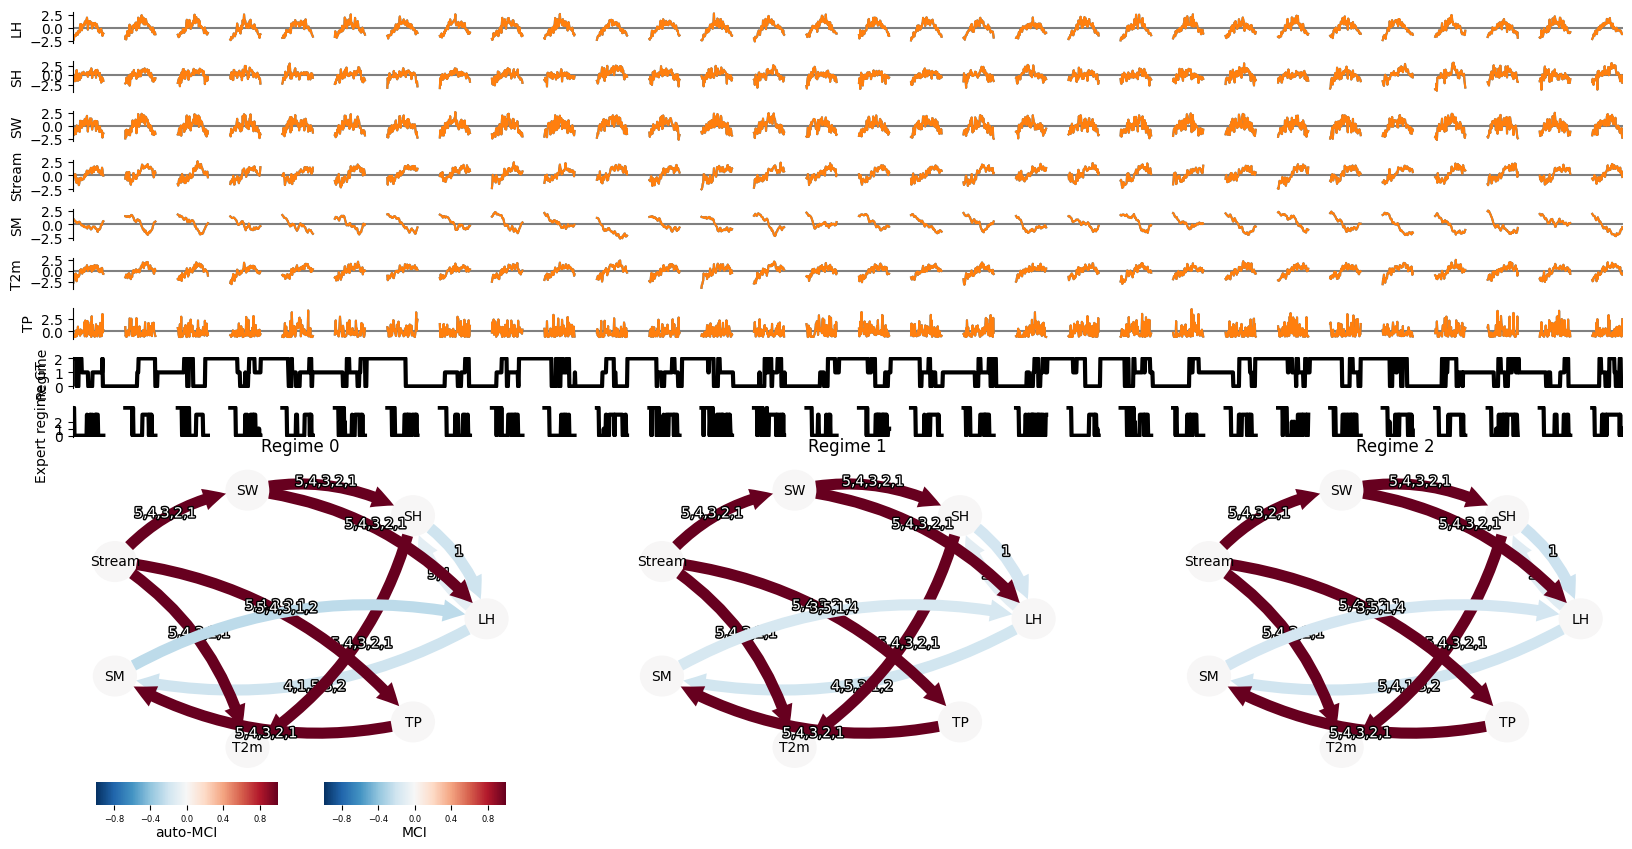

In [34]:
# inspect results
plot_RPCMCI_results(filled_pd_df, filled_vac_values, rpcmci_results_one)

In [35]:
nb_regimes = 2
# Construct mask per regime
T, N = filled_tigramite_df.values[0].shape
regime_indicator = filled_vac_values.copy().astype('int')

masks = {i: np.zeros((T, N)) for i in range(nb_regimes)}

for i, day in enumerate(filled_pd_df.index):
    try:
        t = filled_pd_df.index.get_loc(day)
        if t < T:
            for regime in range(nb_regimes):
                if regime_indicator[i] == regime:
                    masks[regime][[t]] = True
    except KeyError:
        print("KeyError")

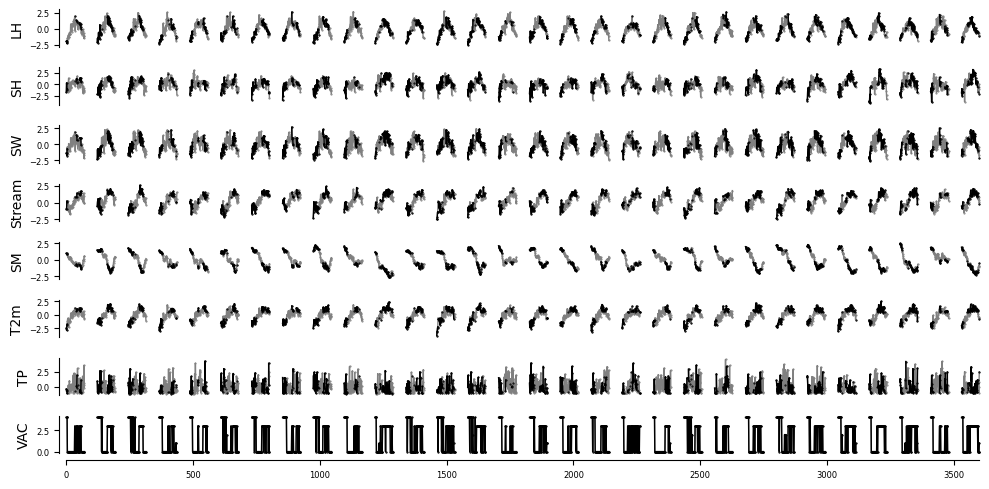

In [36]:
dataframe_regime = pp.DataFrame(np.hstack((filled_pd_df.to_numpy(), filled_vac_values.reshape(T,1))),
                                missing_flag=999.,
                                var_names=list(filled_pd_df.columns) + ["VAC"],
                                mask=np.hstack((masks[0], np.zeros((T, 1)))))
tp.plot_timeseries(dataframe_regime, grey_masked_samples='data', figsize=(10, 5))
plt.show()

In [37]:
def run(regime_index=0):
    dataframe_regime = pp.DataFrame(filled_pd_df.to_numpy(),
                                    missing_flag=999.,
                                    mask=masks[regime_index])
    pcmci = PCMCI(
        dataframe=dataframe_regime,
        cond_ind_test=ParCorr(significance='analytic', mask_type='y'),
        verbosity=0)

    results = pcmci.run_pcmci(tau_max=tau_max,
                              tau_min=tau_min,
                              pc_alpha=pc_alpha,
                              alpha_level=alpha_level,
                              link_assumptions=link_assumptions)
    return results


def plot_masked_results(masked_results, nb_regimes=2):
    fig, axis = plt.subplots(1, nb_regimes, figsize=(20, 5))
    for r in range(nb_regimes):
        tp.plot_graph(
            val_matrix=masked_results[r]['val_matrix'],
            graph=masked_results[r]['graph'],
            var_names=filled_pd_df.columns,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            show_autodependency_lags=False,
            figsize=(10, 10),
            node_size=0.2,
            fig_ax=(fig, axis[r])
        )

In [38]:
masked_results = []
for r in range(nb_regimes):
    res = run(regime_index=r)
    masked_results.append(res)

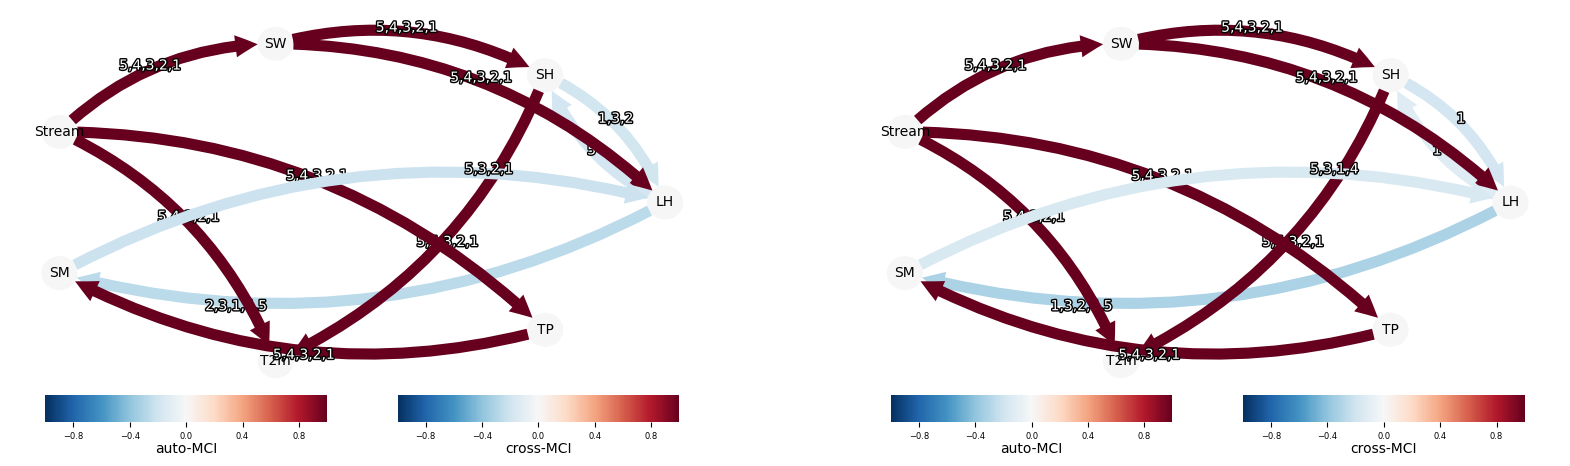

In [39]:
plot_masked_results(masked_results, nb_regimes)

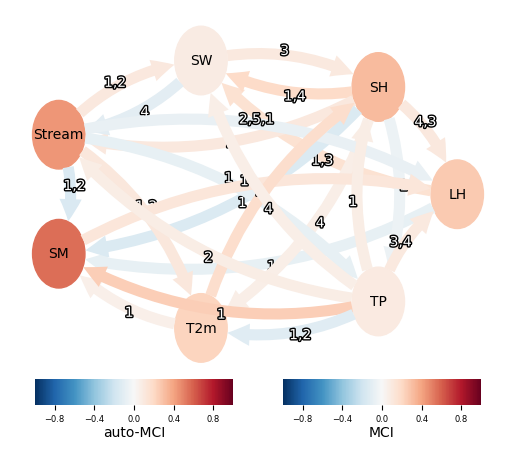

In [40]:
tp.plot_graph(val_matrix=pcmci_results['val_matrix'],
              graph=pcmci_results['graph'], var_names=filled_tigramite_df.var_names,
              node_aspect=0.5, node_size=0.5
              )
plt.show()

In [41]:
## load existing results if necessary
rpcmci_results_without_link_assumptions = dict(enumerate(np.load('\'3D-5-False-3-10-141-0.4-False-True-decisionTree-30years-10iterations-noevap-0.4-new_la_test\'.npy' , allow_pickle=True).flatten()))[0][0]

In [42]:
cp = filled_pd_df.copy()
cp.replace(999., np.nan, inplace=True)
filled_for_plotting = filled_vac_values.copy()
filled_for_plotting[filled_for_plotting == 999.] = np.nan

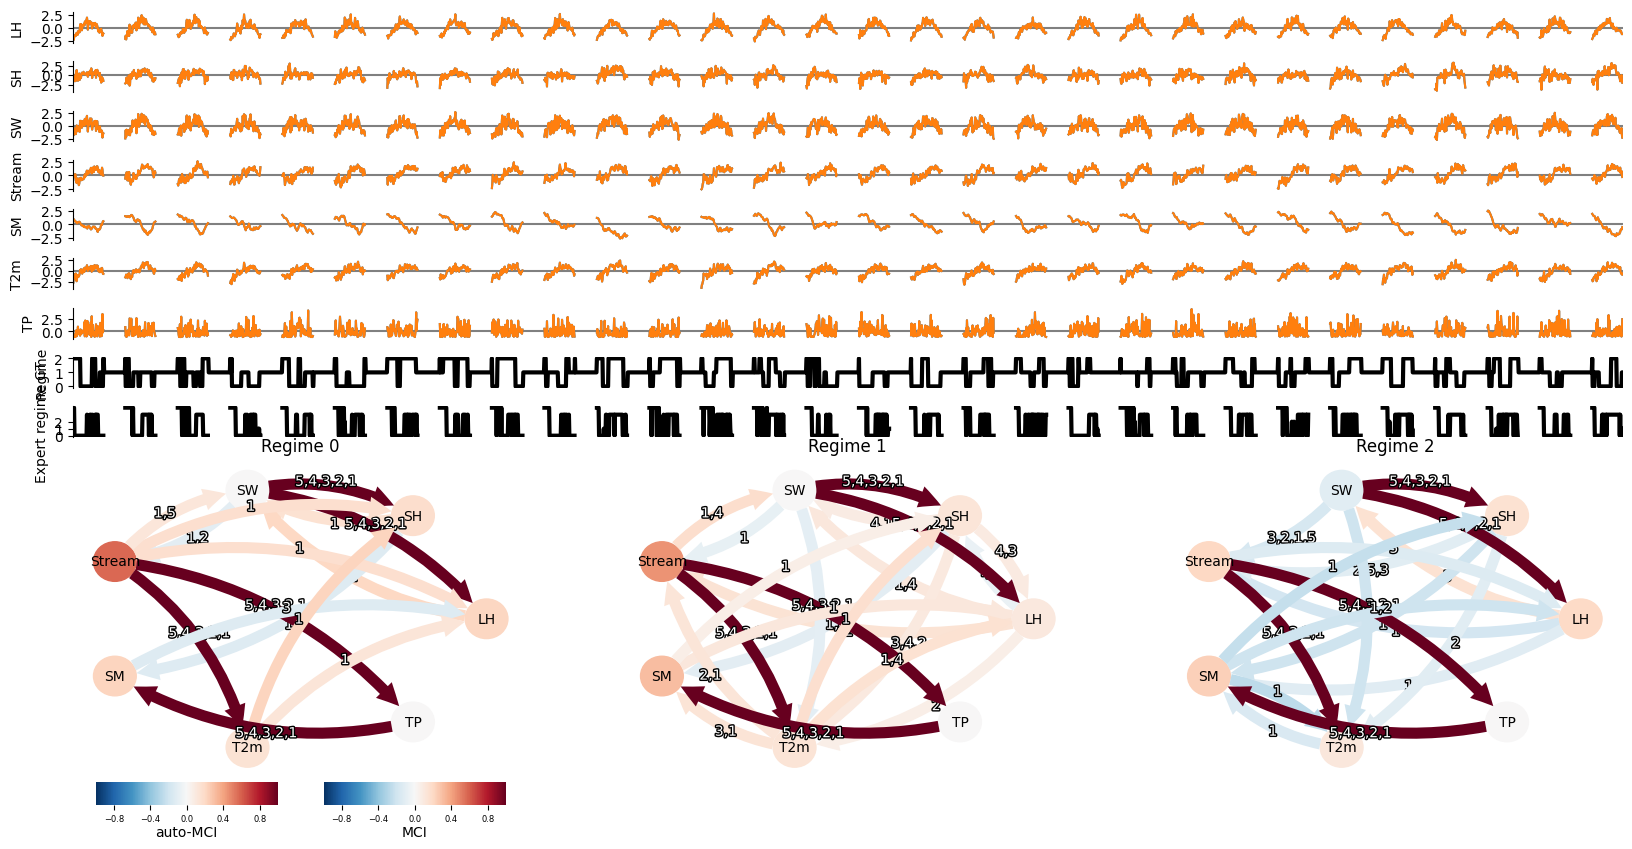

In [43]:
plot_RPCMCI_results(filled_pd_df, filled_vac_values, rpcmci_results_without_link_assumptions)

In [44]:
## load existing results if necessary
rpcmci_results_with_link_assumptions = dict(enumerate(np.load('\'3D-5-False-3-10-142-0.4-False-True-decisionTree-v1-mean-30years-10iterations-noevap-0.4\'.npy' , allow_pickle=True).flatten()))[0][0]

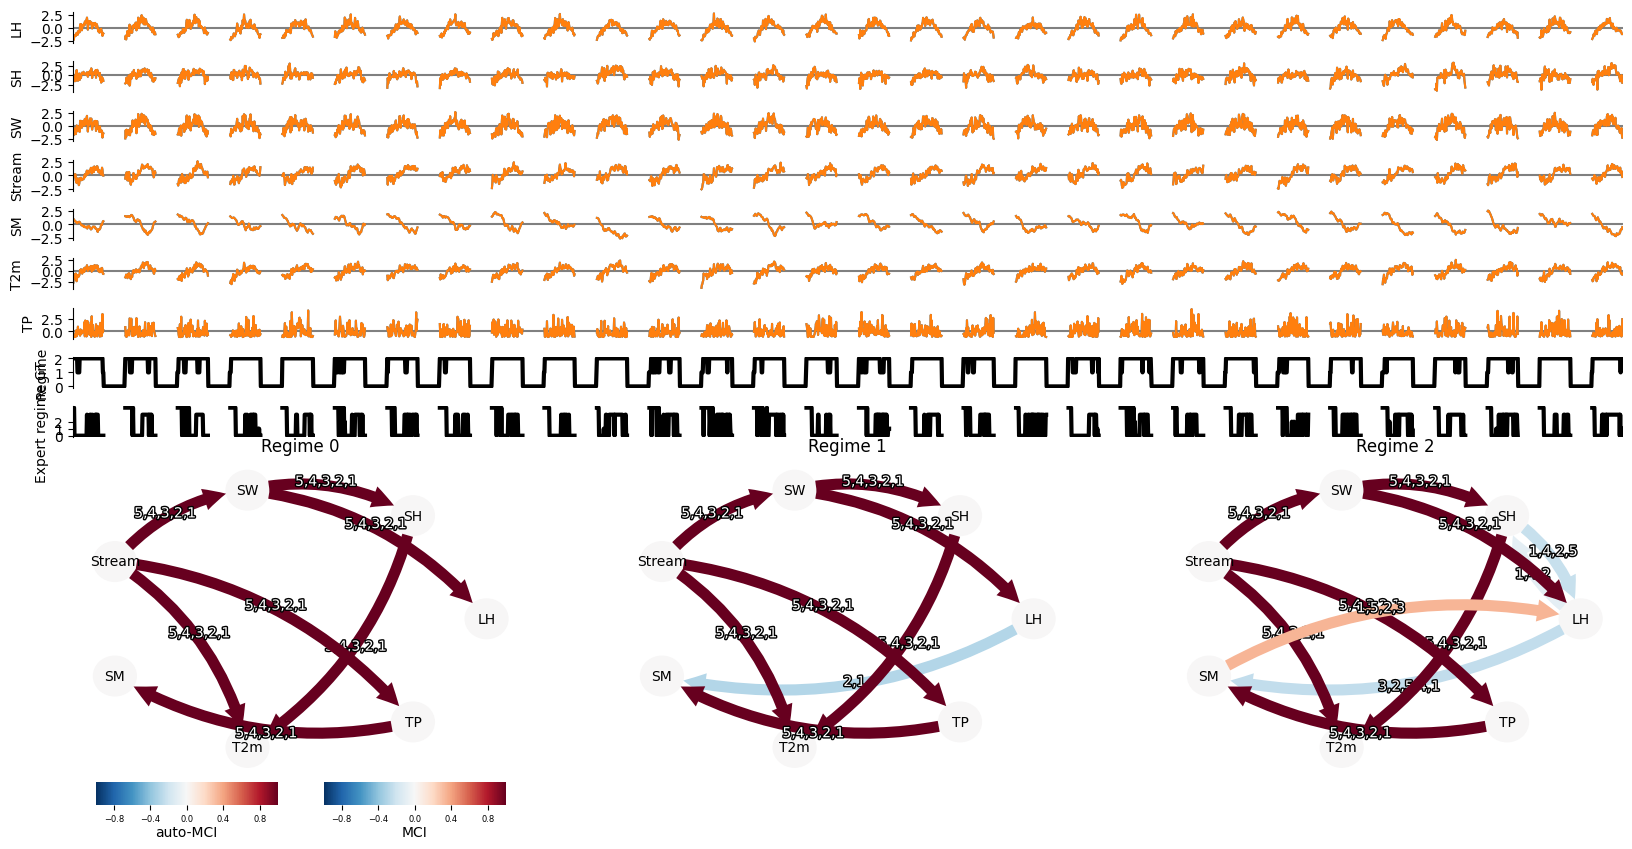

In [45]:
plot_RPCMCI_results(filled_pd_df, filled_vac_values, rpcmci_results_with_link_assumptions)

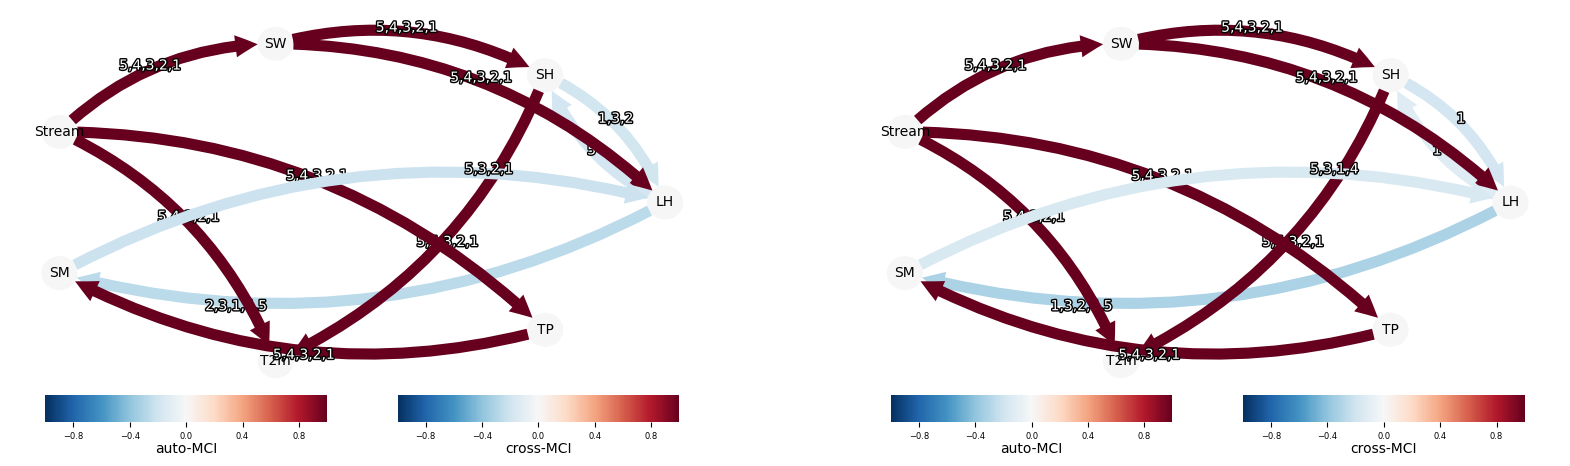

In [46]:
plot_masked_results(masked_results, nb_regimes)